# Overview

This notebook demonstrates how to parse “Race Lap Analysis” PDF. The high-level steps to process a page are as follows:

1. get the page width $w$. The width is shared by three drivers, so driver $i$’s table is roughly positioned between $\frac{i}{3}w$ and $\frac{i + 1}{3}w$ of the page width. $i$ is 0-indexed
1. get the position ($x, y$) of "Race Lap Analysis". The table will be below this position, i.e. the table's top coordinate is $y$
1. find the word "Page", which appears at the bottom of the page. Let its coordinates be $(a, b)$. The tables are above "Page", so their bottom coordinates are $b$
1. given driver $i$ and his table $i$’s bounding box $(\frac{i}{3}w, y, \frac{i + 1}{3}w, b)$, extract the table
1. the driver's name is above the table's header. So get the position of the table extracted above, and call the top coordinate $h$. The driver's name is vertically bounded between $y$ and $h$, and horizontally still bounded between $\frac{i}{3}w$ and $\frac{i + 1}{3}w$

<center><img src="../1.svg" width="50%"></center>

# Get the bounding box of the tables

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Some aesthetic settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
rc = {'figure.figsize': (4, 3),
      'axes.facecolor': 'white',             # Remove background colour
      'axes.grid' : False,                   # Turn on grid
      'axes.linewidth': '0.2',
      'axes.edgecolor': '0',                 # Set axes edge color to be black
      'font.size': 2,
      'xtick.major.size': 1,
      'xtick.major.width': 0.2,
      'ytick.major.size': 1,
      'ytick.major.width': 0.2}
plt.rcdefaults()
plt.rcParams.update(rc)


def show_image(item):
    """Display a pixmap

    :param item: Any PyMuPDF object having a "get_pixmap" method

    Just to display Pixmap image of "item" - ignore the man behind the curtain. Generates an RGB
    pixmap from item using a constant DPI and using matplotlib to show it inline of the notebook
    """
    DPI = 600
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))
    pass

In [33]:
import fitz

# Page width
doc = fitz.open('../1.pdf')
page = doc[0]
w = page.bound()[2]

# Position of "Race Lap Analysis"
y = page.search_for('Race Lap Analysis')[0].y1

# Position of "Page"
b = page.search_for('Page')[0].y0

In [45]:
page.get_text('block', clip=fitz.Rect(i * w / 3, y, (i + 1) * w / 3, h)).strip()

'3\nDaniel RICCIARDO'

Driver 2's number and name: ['3', 'Daniel RICCIARDO']
Driver 2's table 0's col.: ['LAP', '', 'TIME']
Driver 2's table 1's col.: ['LAP', '', 'TIME']


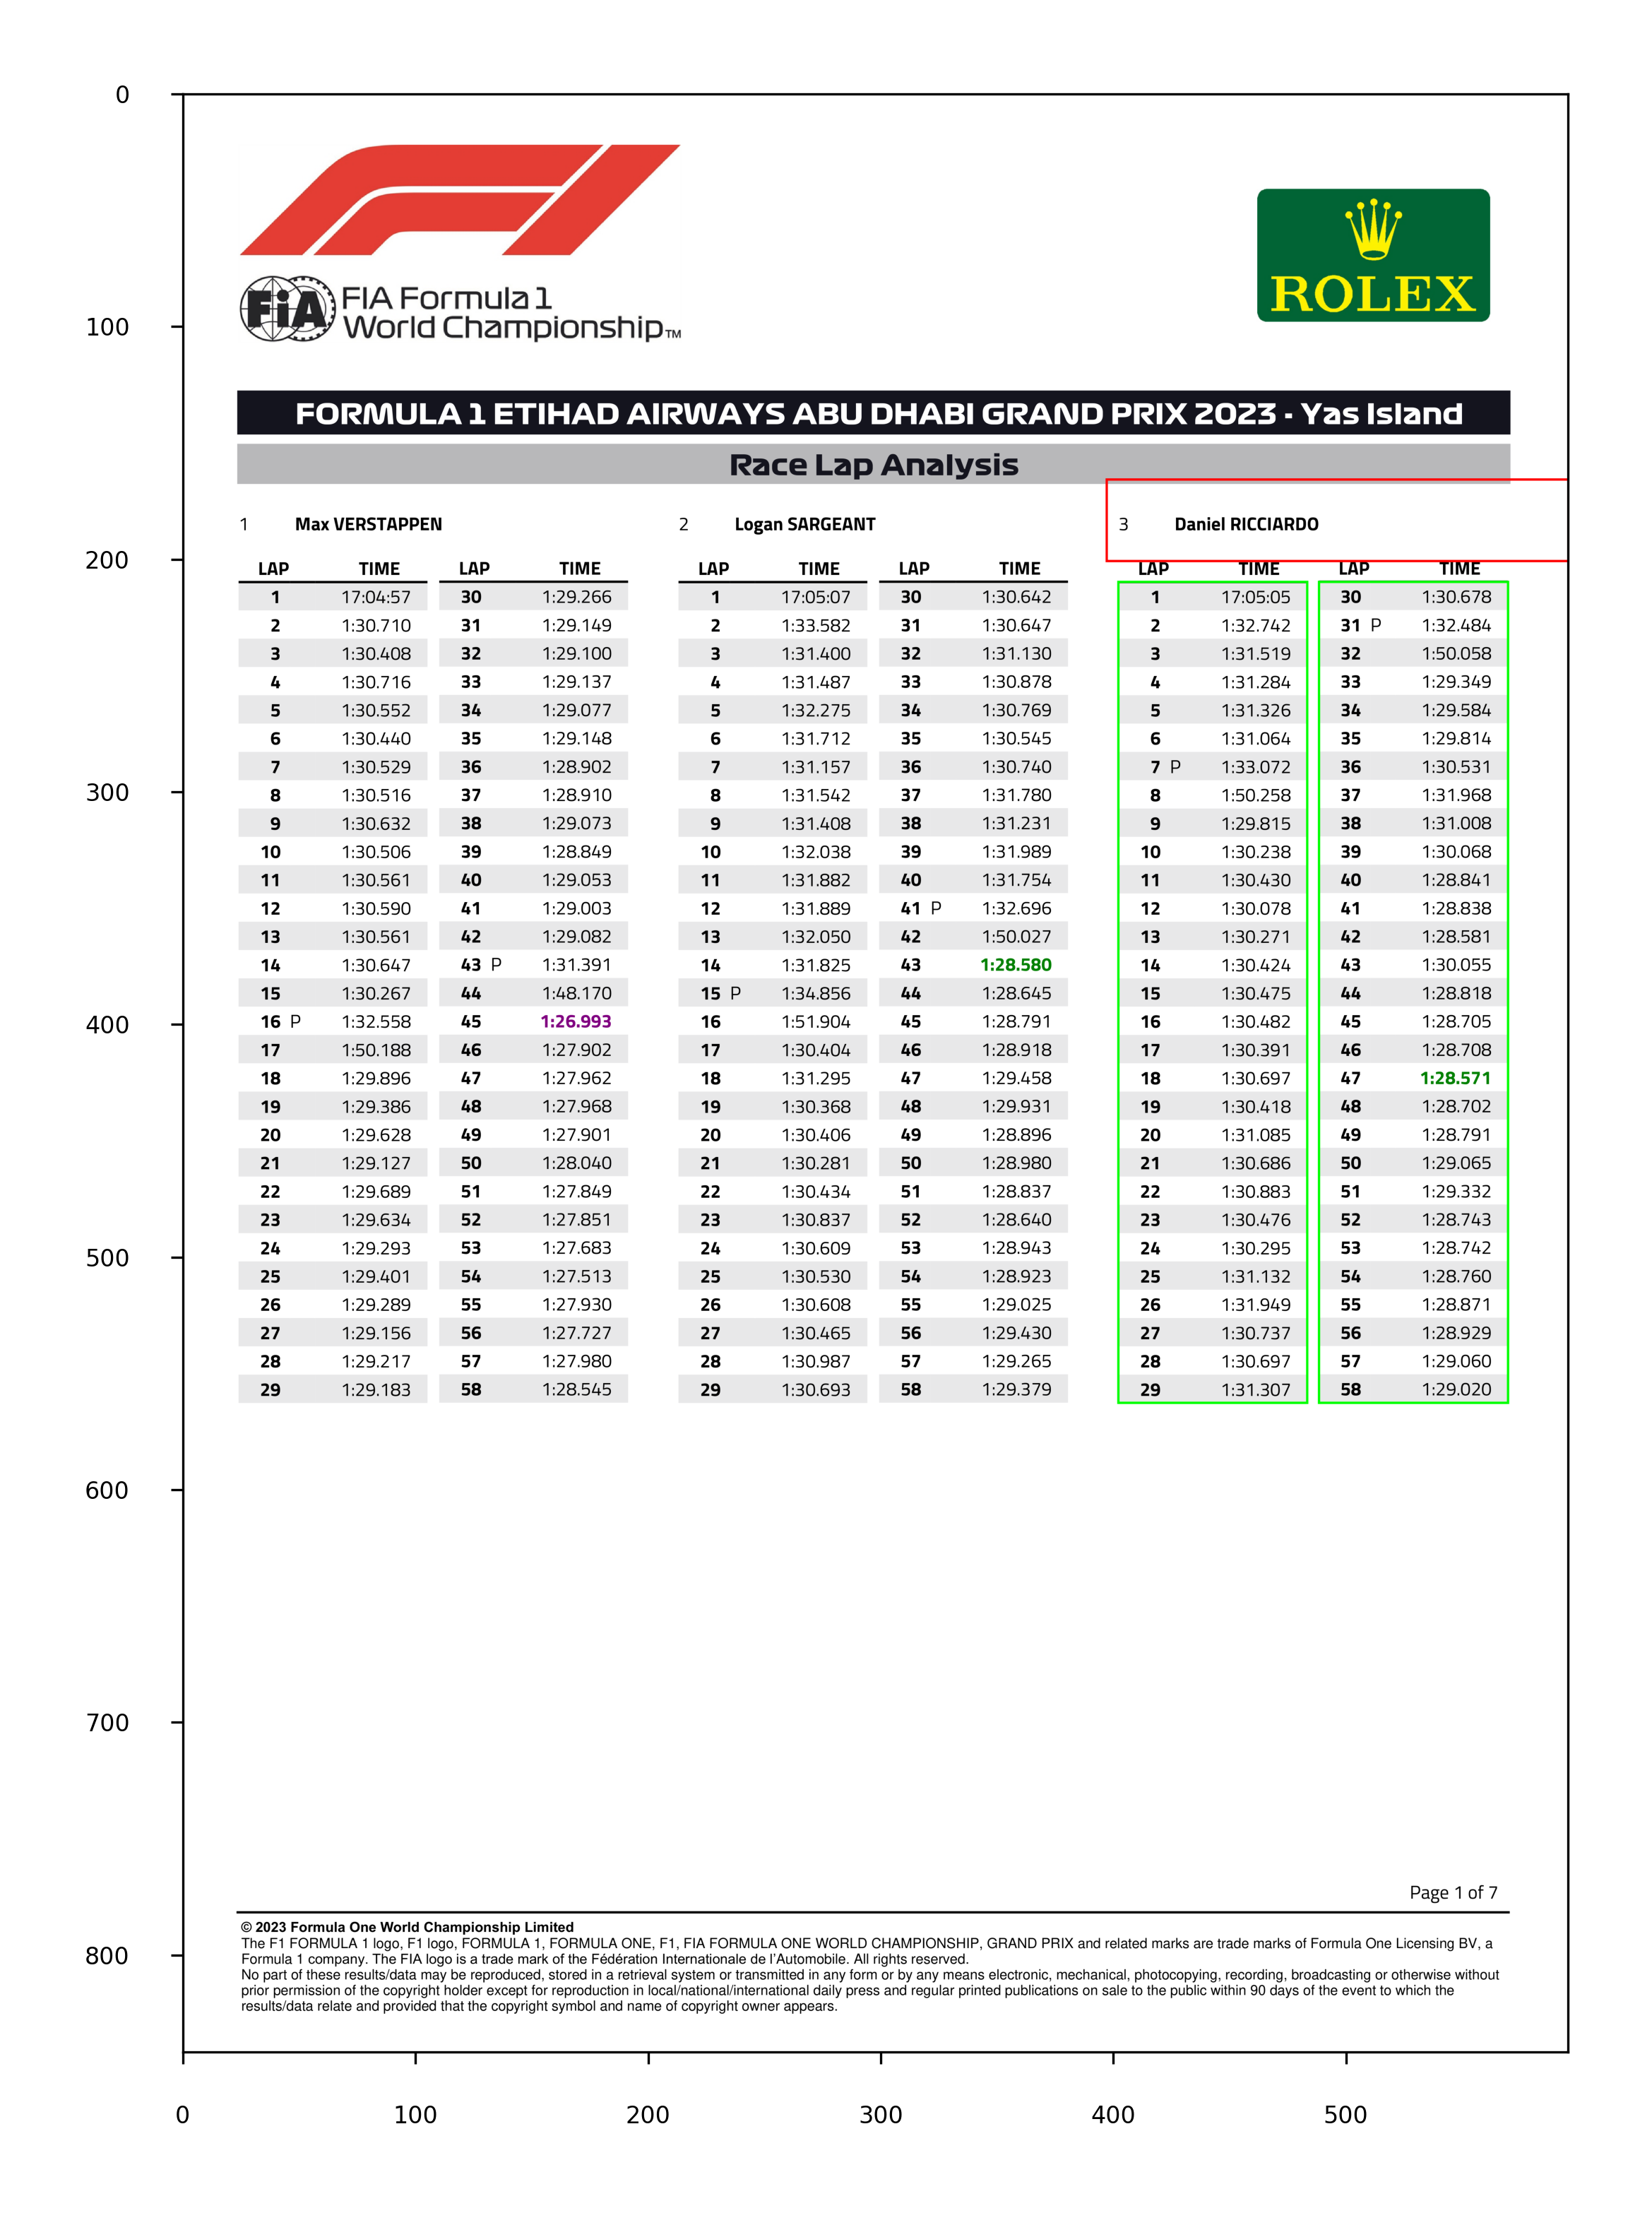

In [53]:
# Find the tables for the third driver (Ric) in page 1
doc = fitz.open('../1.pdf')
page = doc[0]
for i in range(2, 3):

    # Find tables in the bounding box of driver i's table
    tabs = page.find_tables(clip=fitz.Rect(i * w / 3, y, (i + 1) * w / 3, b), strategy='lines')

    # Find the position of a table' header
    h = tabs[0].header.bbox[1]

    # The driver's name is between `h` and `y`
    name = page.get_text('block', clip=fitz.Rect(i * w / 3, y, (i + 1) * w / 3, h)).strip()
    page.draw_rect(fitz.Rect(i * w / 3, y, (i + 1) * w / 3, h), color=fitz.pdfcolor['red'])
    print((f"Driver {i}'s number and name: {name.split(maxsplit=1)}"))

    # Mark the tables for visualisation
    for j, tab in enumerate(tabs):  # iterate over all tables
        page.draw_rect(tab.bbox, color=fitz.pdfcolor['green'])
        print(f"Driver {i}'s table {j}'s col.: {tab.header.names}")

show_image(page)

In [4]:
tabs[0].to_pandas().head()

,LAP,Col1,TIME
0,1,,17:05:05
1,2,,1:32.742
2,3,,1:31.519
3,4,,1:31.284
4,5,,1:31.326


# Stuff that doesn't work

* table transformer (Smock et al., CVPR [2022](https://arxiv.org/pdf/2110.00061.pdf))
    + it does not recognise the table structure at all... I'm following this [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb); maybe something wrong with my code?